In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.1 MB/s 


# Trabajo final de Prácticas de IAA

El problema seleccionado trata sobre la clasificación del dataset CIFAR10 (https://www.tensorflow.org/datasets/catalog/cifar10), el cual consta de las siguientes clases a clasificar:

| Label 	| Description 	|
|:-----:	|:-----------:	|
|   0   	|   airplane  	|
|   1   	|  automobile 	|
|   2   	|     bird    	|
|   3   	|     cat     	|
|   4   	|     deer    	|
|   5   	|     dog     	|
|   6   	|     frog    	|
|   7   	|    horse    	|
|   8   	|     ship    	|
|   9   	|    truck    	|

# Imports y procesamiento del dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
def load_dataset() -> tuple:
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

  assert x_train.shape == (50000, 32, 32, 3)
  assert x_test.shape == (10000, 32, 32, 3)
  assert y_train.shape == (50000, 1)
  assert y_test.shape == (10000, 1)

  return (x_train, y_train), (x_test, y_test)

In [ ]:
(x_train, y_train), (x_test, y_test) = load_dataset()

170508288/170498071 [==============================] - 13s 0us/step


Impresión de imágenes aleatorias del dataset

(32, 32, 3)


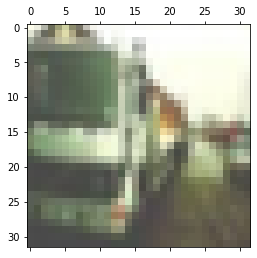

In [ ]:
random_index = random.randint(0, x_train.shape[0] - 1)

plt.matshow(x_train[random_index])
dimensions = x_train[random_index].shape

# 32x32 with 3 channels
print(dimensions)

# Preprocesamiento de imágenes

In [ ]:
# Normalizing image values 

x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
# transform labels to categorical values

N_CLASSES = 10
y_train = keras.utils.to_categorical(y_train, N_CLASSES)
print("Y_train shape/type changed to ", y_train.shape, y_train.dtype)

# 10 posibles outputs
y_test = keras.utils.to_categorical(y_test, N_CLASSES)

Y_train shape/type changed to  (50000, 10) float32


# Modelo clásico

In [ ]:
""" Modelo optimizable con Keras Tuner """

import keras
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

def classic_model(hp):
  model = Sequential()
  model.add(keras.layers.Flatten(input_shape=(32, 32, 3)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=8)
  hp_activation = hp.Choice('activation_function', values=['elu', 'relu'])
  model.add(keras.layers.Dense(units=hp_units, activation=str(hp_activation)))
  hp_dropout = hp.Choice('dropout_2', values=[0.1,0.2,0.3,0.4,0.5])
  model.add(Dropout(hp_dropout))

  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
  import keras
  import keras,os
  from keras.models import Sequential
  from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Input
  from keras.preprocessing.image import ImageDataGenerator
  import numpy as np
  from keras import regularizers
  from keras.callbacks import LearningRateScheduler
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
  from keras.layers.convolutional import Conv2D
  from keras.layers.pooling import MaxPooling2D
  from keras.models import Model
  from tensorflow.keras.optimizers import SGD, Adam

  
  def classic_model():
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(424, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    
    return model

In [ ]:
from keras_tuner import RandomSearch

tuner = RandomSearch(classic_model,
                    objective='val_accuracy',
                    max_trials=100)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
tuner.search(x_train, y_train, epochs=3, validation_split=0.2 , callbacks=[stop_early])

Trial 100 Complete [00h 00m 21s]
val_accuracy: 0.4097999930381775

Best val_accuracy So Far: 0.4239000082015991
Total elapsed time: 00h 28m 39s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)

In [ ]:
eval_result = hypermodel.evaluate(x_train, y_train)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
hypermodel.save('classic_model_optimized.h5')

NameError: ignored

In [ ]:
""" Modelo vanilla sin optimizar """

model = classic_model()

model.summary()

history = model.fit(x_train, y_train, validation_split=0.2, epochs=100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 424)               1302952   
                                                                 
 dropout_2 (Dropout)         (None, 424)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                4250      
                                                                 
Total params: 1,307,202
Trainable params: 1,307,202
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1250/1250 [==============================] - 6s 5ms/step - loss: 1.9045 - accuracy: 0.3160 - val_loss: 1.7749 - val_accuracy: 0.3750
Epoch 2/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7416 - accuracy: 0.3853 - val_loss: 1.7100 - val_accuracy: 0.3918
Epoch 3/100
1250/1250 [==============================] - 6s 4ms/step - loss: 1.6774 - accuracy: 0.4083 - val_loss: 1.6495 - val_accuracy: 0.4274
Epoch 4/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6348 - accuracy: 0.4226 - val_loss: 1.6167 - val_accuracy: 0.4377
Epoch 5/100
1250/1250 [==============================] - 6s 4ms/step - loss: 1.5983 - accuracy: 0.4349 - val_loss: 1.5992 - val_accuracy: 0.4341
Epoch 6/100
1250/1250 [==============================] - 6s 4ms/step - loss: 1.5668 - accuracy: 0.4482 - val_loss: 1.5820 - val_accuracy: 0.4512
Epoch 7/100
1250/1250 [==============================] - 6s 4ms/step - loss: 1.5439 - accuracy: 0.4581 - val_loss: 1.5512 - val_accuracy: 0.45

In [ ]:
# Conexión a Goolge Drive para descargar el dataset.
from google.colab import drive
drive.mount('/content/gdrive')

# Guardamos el mejor modelo
model.save('/content/gdrive/MyDrive/Prácticas IAA/best_classic_model.h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 1.4342 - accuracy: 0.5375 - 830ms/epoch - 3ms/step


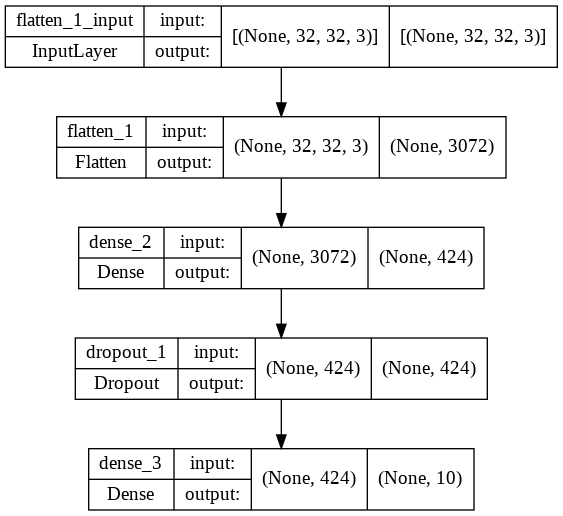

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

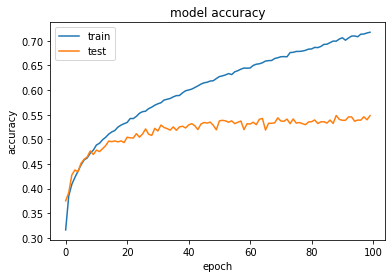

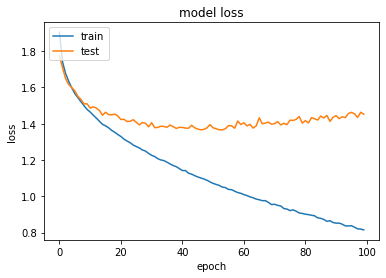

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Modelo convolucional I

In [ ]:
def create_model() -> keras.Sequential:
  # Modelo secuencial
  cifar10_model = tf.keras.models.Sequential()

  # Agrego la capa de entrada donde específico el tamaño de los datos de entrada
  cifar10_model.add(tf.keras.layers.Input(shape=(32, 32, 3)))

  # Agrego una capa convolucional con 32 filtros, con kernel size 3, dejando el mismo tamaño inicial (padding=same)
  # Y aplico la activación mediante ReLU
  cifar10_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))

  # Capa de maxpool, pool_size -> Tamaño máximo de la ventana
  # Strides, especifica cuanto recorre en cada paso que se realize en el pooling
  cifar10_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))

  # Dropout layer permite generar conexiones aleatorias entre las capas
  cifar10_model.add(tf.keras.layers.Dropout(0.4))

  #Agrego capa de Conv2D
  cifar10_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))

  #Agrego capa de maxpool
  cifar10_model.add(tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=(2,2)))

  
   #Agrego capa de Conv2D
  cifar10_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))

  #Agrego capa de maxpool
  cifar10_model.add(tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=(2,2)))

  # Agrego la capa final (capa de 1 dimensión final)
  cifar10_model.add(tf.keras.layers.Flatten())



  # Debe distinguir entre 10 clases (categorías a clasificar) que se eligen mediante softmax
  cifar10_model.add(tf.keras.layers.Dense(10, activation="softmax"))

  return cifar10_model

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

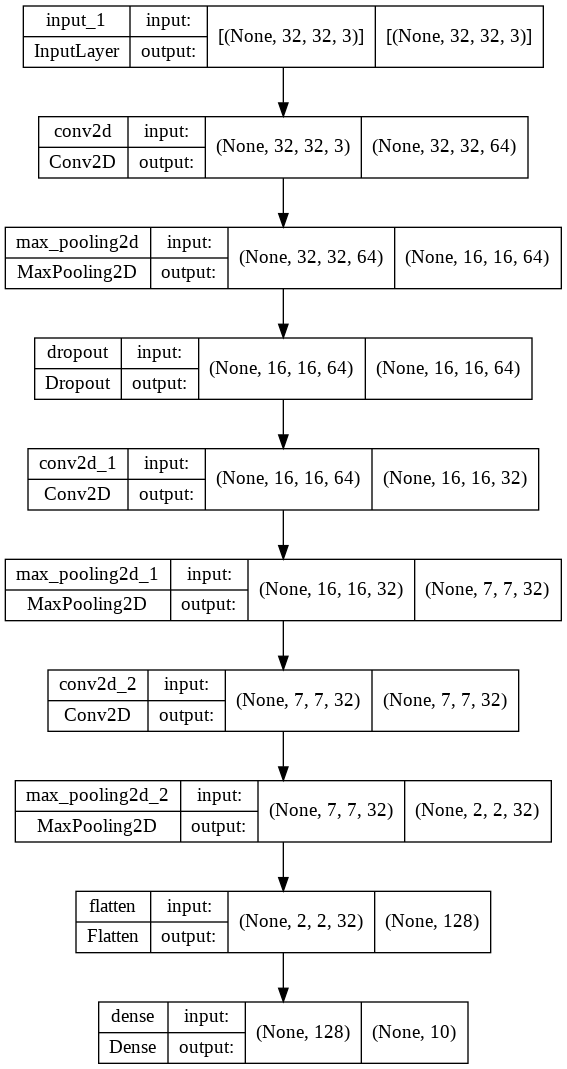

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')
import tensorflow as tf


In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
400/400 [==============================] - 14s 7ms/step - loss: 1.8937 - accuracy: 0.2985 - val_loss: 1.6238 - val_accuracy: 0.4080
Epoch 2/100
400/400 [==============================] - 3s 7ms/step - loss: 1.5450 - accuracy: 0.4413 - val_loss: 1.4552 - val_accuracy: 0.4779
Epoch 3/100
400/400 [==============================] - 3s 7ms/step - loss: 1.4138 - accuracy: 0.4915 - val_loss: 1.3883 - val_accuracy: 0.4991
Epoch 4/100
400/400 [==============================] - 3s 7ms/step - loss: 1.3333 - accuracy: 0.5247 - val_loss: 1.2985 - val_accuracy: 0.5373
Epoch 5/100
400/400 [==============================] - 3s 7ms/step - loss: 1.2625 - accuracy: 0.5511 - val_loss: 1.1911 - val_accuracy: 0.5830
Epoch 6/100
400/400 [==============================] - 3s 6ms/step - loss: 1.2019 - accuracy: 0.5752 - val_loss: 1.1584 - val_accuracy: 0.5959
Epoch 7/100
400/400 [==============================] - 3s 7ms/step - loss: 1.1513 - accuracy: 0.5923 - val_loss: 1.1014 - val_accuracy: 0.613

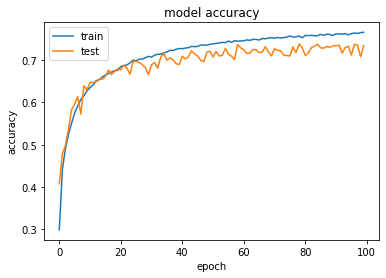

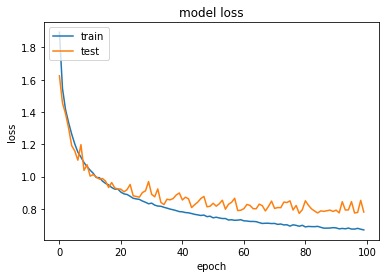

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Cargamos tensorflow que contiene a Keras.
import tensorflow as tf

# Conexión a Goolge Drive para descargar el dataset.
from google.colab import drive
drive.mount('/content/gdrive')

# Guardamos el mejor modelo
model.save('/content/gdrive/MyDrive/Prácticas IAA/best_conv_I_model4.h5')

Mounted at /content/gdrive


# Modelo convolucional II

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

def create_conv_model():

  weight_decay = 1e-4
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
 
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
 
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))
 
  model.add(Flatten())
  model.add(Dense(N_CLASSES, activation='softmax'))

  return model

In [ ]:
model = create_conv_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                      

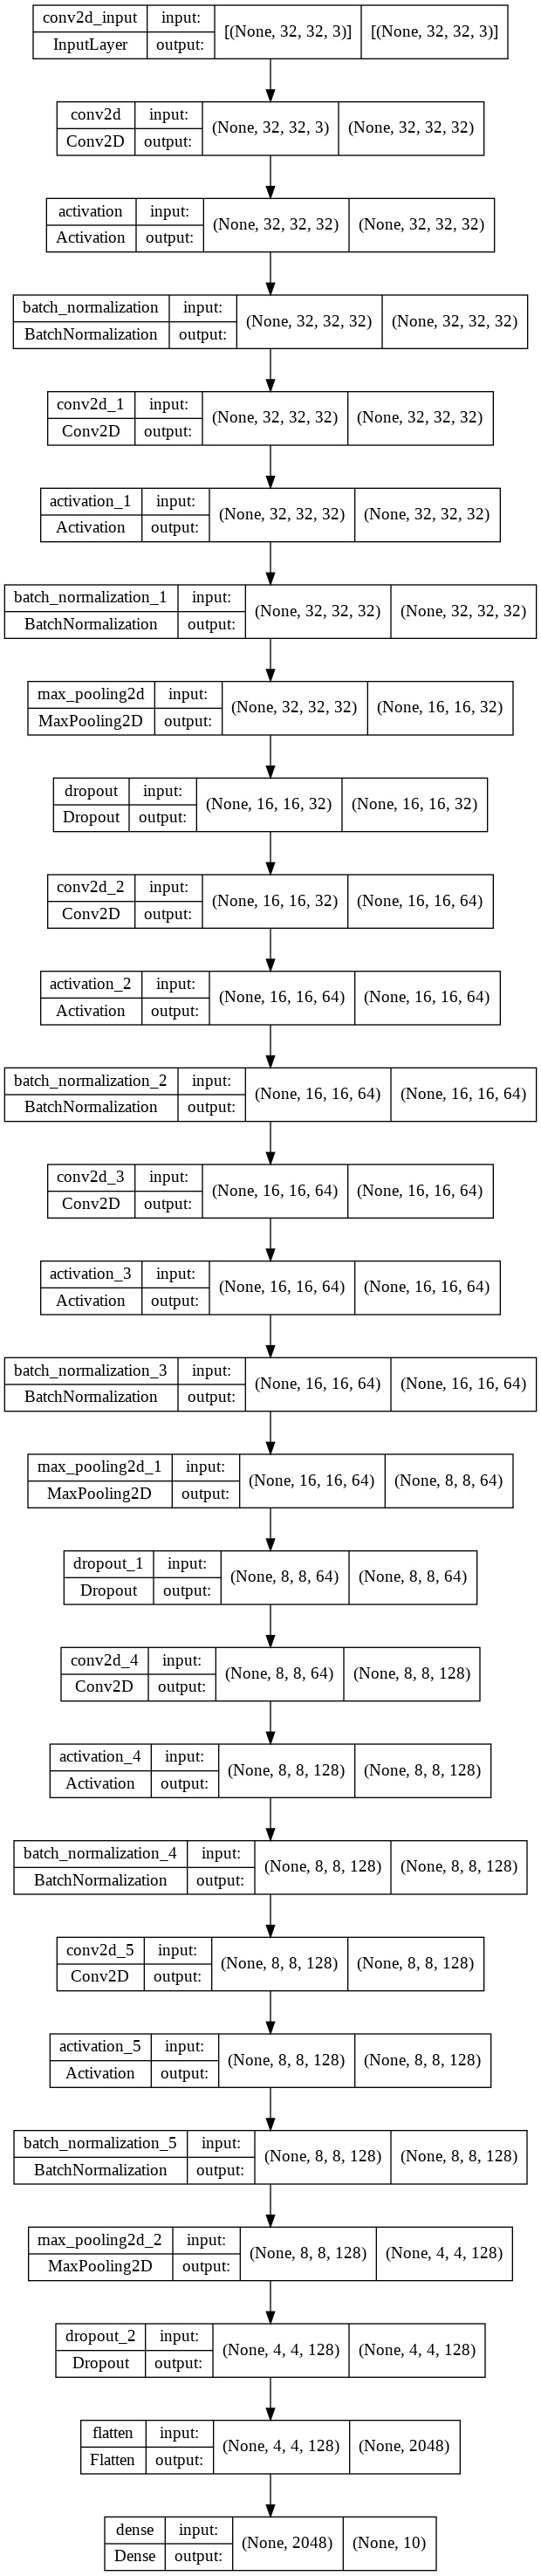

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
from google.colab import files
files.download('model.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Hiperparámetros para el entrenamiento

INIT_LR = 1e-3
NUM_EPOCHS = 100

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam

opt = Adam(learning_rate=INIT_LR)

In [ ]:
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# Distorsionamos las imágenes para reducir así el over-fitting

aug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, fill_mode="nearest")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

def poly_decay(epoch): # Learning rate shcheduler
    maxEpochs = NUM_EPOCHS
    baseLR = INIT_LR
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

# Es interesante agregar un earlyStopping, pero como tenemos un checkpoint guardará igualmente el mejor modelo
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

callbacks = [LearningRateScheduler(poly_decay),
             ModelCheckpoint('/content/gdrive/MyDrive/Prácticas IAA/best_model.h5', monitor='val_accuracy', 
                             mode='max', verbose=1, save_best_only=True)]

# Guardaremos el mejor modelo encontrado hasta el momento

In [ ]:
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

In [ ]:
history = model.fit(aug.flow(x_train, y_train, batch_size=64),
          validation_data=(x_test, y_test),
          steps_per_epoch=len(x_train) // 64,
          epochs=NUM_EPOCHS,
          callbacks=callbacks,
          verbose=1)

Epoch 1/100
780/781 [============================>.] - ETA: 0s - loss: 1.8787 - accuracy: 0.4128
Epoch 1: val_accuracy improved from -inf to 0.46910, saving model to /content/gdrive/MyDrive/Prácticas IAA/best_model.h5
781/781 [==============================] - 61s 62ms/step - loss: 1.8781 - accuracy: 0.4129 - val_loss: 1.7893 - val_accuracy: 0.4691 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 1.2585 - accuracy: 0.5826
Epoch 2: val_accuracy improved from 0.46910 to 0.66440, saving model to /content/gdrive/MyDrive/Prácticas IAA/best_model.h5
781/781 [==============================] - 49s 62ms/step - loss: 1.2585 - accuracy: 0.5826 - val_loss: 1.0359 - val_accuracy: 0.6644 - lr: 9.9000e-04
Epoch 3/100
781/781 [==============================] - ETA: 0s - loss: 1.0466 - accuracy: 0.6545
Epoch 3: val_accuracy did not improve from 0.66440
781/781 [==============================] - 49s 62ms/step - loss: 1.0466 - accuracy: 0.6545 - val_loss: 1.1316 - val_a

Se puede observar que la complejidad del modelo es adecuada (equilibrio entre bias y varianza), sin embargo el learning rate en épocas futuras se sigue mantieniendo alto, por tanto será necesario implementar un scheduler del lr

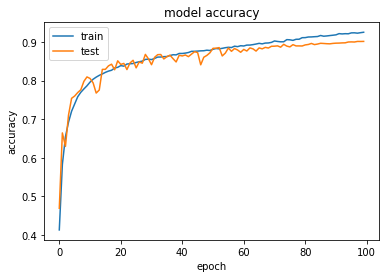

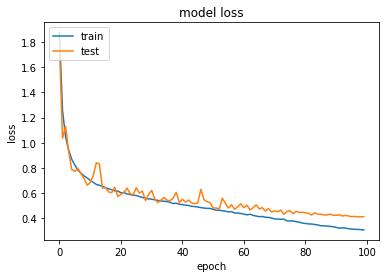

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Guardamos el mejor modelo**

In [ ]:
#Cargamos tensorflow que contiene a Keras.
import tensorflow as tf

# Conexión a Goolge Drive para descargar el dataset.
from google.colab import drive
drive.mount('/content/gdrive')

# Guardamos el mejor modelo
model.save('gdrive/MyDrive/best_conv_II_model.h5')

Mounted at /content/gdrive


In [ ]:
!ls gdrive/MyDrive/

 best_conv_II_model.h5	'Prácticas IAA'


**Learning rate scheduler: Time-based decay and exponential decay**

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

decay = 0.01 # Learning rate inicial del optimizador Adam
def lr_time_based_decay(epoch, lr):
        return lr * 1 / (1 + decay * epoch)

callbacks = []
callbacks.append(LearningRateScheduler(lr_time_based_decay, verbose=1))

In [ ]:
model2.compile(optimizer='Adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

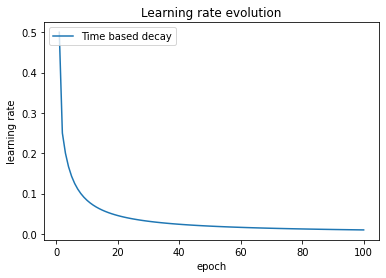

In [ ]:
lr = 0.5
epochs = 100

current_lr = []
current_epoch = []

current_lr.append(lr)
current_epoch.append(1)

for epoch in range(2, epochs + 1):
  current_lr.append(lr * 1 / (1 + 0.5 * epoch))
  current_epoch.append(epoch)

plt.plot(current_epoch, current_lr)
plt.title('Learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.legend(['Time based decay'], loc='upper left')
plt.show()

In [ ]:
history2 = model2.fit(x_train, y_train, epochs=100, batch_size=1000, validation_split=0.2, callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
40/40 [==============================] - 11s 239ms/step - loss: 2.3539 - accuracy: 0.3345 - val_loss: 2.7133 - val_accuracy: 0.1321 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009900990569281696.
Epoch 2/100
40/40 [==============================] - 10s 239ms/step - loss: 1.6700 - accuracy: 0.4620 - val_loss: 2.7359 - val_accuracy: 0.1669 - lr: 9.9010e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009706853341092082.
Epoch 3/100
40/40 [==============================] - 9s 238ms/step - loss: 1.4138 - accuracy: 0.5335 - val_loss: 2.7862 - val_accuracy: 0.1994 - lr: 9.7069e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009424129424128428.
Epoch 4/100
40/40 [==============================] - 9s 224ms/step - loss: 1.2457 - accuracy: 0.5886 - val_loss: 2.7051 - val_accuracy: 0.1666 - lr: 9.4241e-04

Epoch 5: LearningRateScheduler setting le

En este caso se puede observar que el learnig rate es demasiado bajo, por tanto será recomendable optar por un learning rate más alto de base, o por un scheduler menos agresivo, ya que se puede observar un estancamiento dado el bajo learning rate

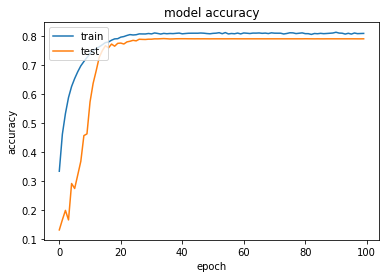

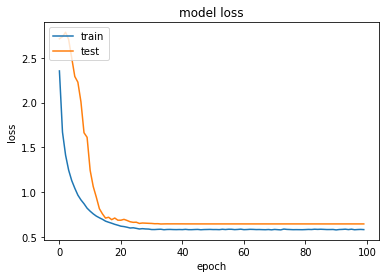

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Optimización del modelo final mediante keras tuner

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

def create_model_keras_tuner(hp):
  model = Sequential()

  """PRIMERA CAPA CONVOLUCIONAL"""
  #############################
  weight_decay = hp.Choice('weight_decay_1', values=[1e-1,1e-2,1e-3,1e-4])
  activation = hp.Choice('activation_function_1', values=['elu', 'relu'])
  regularizer_str = hp.Choice('kernel_regularizer_1', values=['l1', 'l2'])
  model.add(Conv2D(32, 
                   (3,3), 
                   padding='same', 
                   kernel_regularizer=regularizers.l1(weight_decay) if regularizer_str == 'l1' else regularizers.l2(weight_decay), 
                   input_shape=x_train.shape[1:]))
  model.add(Activation(str(activation)))
  model.add(BatchNormalization())
  #############################

  """SEGUNDA CAPA CONVOLUCIONAL"""
  #############################
  weight_decay = hp.Choice('weight_decay_2', values=[1e-1,1e-2,1e-3,1e-4])
  activation = hp.Choice('activation_function_2', values=['elu', 'relu'])
  regularizer_str = hp.Choice('kernel_regularizer_2', values=['l1', 'l2'])
  model.add(Conv2D(32, 
                   (3,3) ,
                   padding='same', 
                   kernel_regularizer=regularizers.l1(weight_decay) if regularizer_str == 'l1' else regularizers.l2(weight_decay), 
                   input_shape=x_train.shape[1:]))
  model.add(Activation(str(activation)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  #############################

  dropout = hp.Choice('dropout_1', values=[0.1,0.2,0.3,0.4,0.5])
  model.add(Dropout(dropout))

  """TERCERA CAPA CONVOLUCIONAL"""
  #############################
  weight_decay = hp.Choice('weight_decay_3', values=[1e-1,1e-2,1e-3,1e-4])
  activation = hp.Choice('activation_function_3', values=['elu', 'relu'])
  regularizer_str = hp.Choice('kernel_regularizer_3', values=['l1', 'l2'])
  model.add(Conv2D(64, 
                   (3,3), 
                   padding='same', 
                   kernel_regularizer=regularizers.l1(weight_decay) if regularizer_str == 'l1' else regularizers.l2(weight_decay), 
                   input_shape=x_train.shape[1:]))
  model.add(Activation(str(activation)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  #############################

  """CUARTA CAPA CONVOLUCIONAL"""
  #############################
  weight_decay = hp.Choice('weight_decay_4', values=[1e-1,1e-2,1e-3,1e-4])
  activation = hp.Choice('activation_function_4', values=['elu', 'relu'])
  regularizer_str = hp.Choice('kernel_regularizer_4', values=['l1', 'l2'])
  model.add(Conv2D(64, 
                   (3,3), 
                   padding='same', 
                   kernel_regularizer=regularizers.l1(weight_decay) if regularizer_str == 'l1' else regularizers.l2(weight_decay), 
                   input_shape=x_train.shape[1:]))
  model.add(Activation(str(activation)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  #############################
  
  dropout = hp.Choice('dropout_2', values=[0.1,0.2,0.3,0.4,0.5])
  model.add(Dropout(dropout))

  """QUINTA CAPA CONVOLUCIONAL"""
  #############################
  weight_decay = hp.Choice('weight_decay_5', values=[1e-1,1e-2,1e-3,1e-4])
  activation = hp.Choice('activation_function_5', values=['elu', 'relu'])
  regularizer_str = hp.Choice('kernel_regularizer_5', values=['l1', 'l2'])
  model.add(Conv2D(128, 
                   (3,3), 
                   padding='same', 
                   kernel_regularizer=regularizers.l1(weight_decay) if regularizer_str == 'l1' else regularizers.l2(weight_decay), 
                   input_shape=x_train.shape[1:]))
  model.add(Activation(str(activation)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  #############################

  """SEXTA CAPA CONVOLUCIONAL"""
  #############################
  weight_decay = hp.Choice('weight_decay_6', values=[1e-1,1e-2,1e-3,1e-4])
  activation = hp.Choice('activation_function_6', values=['elu', 'relu'])
  regularizer_str = hp.Choice('kernel_regularizer_6', values=['l1', 'l2'])
  model.add(Conv2D(128, 
                   (3,3), 
                   padding='same', 
                   kernel_regularizer=regularizers.l1(weight_decay) if regularizer_str == 'l1' else regularizers.l2(weight_decay), 
                   input_shape=x_train.shape[1:]))
  model.add(Activation(str(activation)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  #############################
  
  dropout = hp.Choice('dropout_3', values=[0.1,0.2,0.3,0.4,0.5])
  model.add(Dropout(dropout))

  """CAPA FINAL"""
  #############################
  model.add(Flatten())
  model.add(Dense(N_CLASSES, activation='softmax'))
  #############################

  lr = hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3])
  opt = tf.keras.optimizers.Adam(learning_rate=lr)

  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt,
              metrics=['accuracy'])

  return model

In [ ]:
from keras_tuner import RandomSearch

tuner = RandomSearch(create_model_keras_tuner,
                    objective='val_loss',
                    max_trials=100)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
#Cargamos tensorflow que contiene a Keras.
import tensorflow as tf
# Conexión a Goolge Drive para descargar el dataset.

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
from sklearn.model_selection import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

# Buscamos los mejores hiperparámetros
tuner.search(x_train, y_train, epochs=3, validation_split=0.2, batch_size=1000)

#vamos a mostrar un resumen del modelo compilado. Observa el número de parámetros
# a entrenar

# Aquí obtendremos los mejores hiperparámetros para el modelo en cuestión
model=tuner.get_best_models(num_models=1)[0]

# Veremos el resumen del modelo final 
model.summary()

# Guardamos el mejor modelo
model.save('gdrive/MyDrive/Prácticas IAA/best_tuner_conv_model.h5')

Trial 5 Complete [00h 01m 31s]
val_loss: 4.375268936157227

Best val_loss So Far: 4.375268936157227
Total elapsed time: 00h 01m 31s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
0.0001            |0.001             |weight_decay_1
relu              |relu              |activation_function_1
l1                |l2                |kernel_regularizer_1
0.0001            |0.0001            |weight_decay_2
elu               |elu               |activation_function_2
l2                |l1                |kernel_regularizer_2
0.5               |0.5               |dropout_1
0.001             |0.01              |weight_decay_3
relu              |relu              |activation_function_3
l1                |l1                |kernel_regularizer_3
0.001             |0.001             |weight_decay_4
relu              |relu              |activation_function_4
l1                |l2                |kernel_regularizer_4
0.3               |0.5               |dropout_2
0.1 

# Uso de modelo pre-entrenado como capa de entrada

La utilización de este tipo de modelo será interesante puesto que nos ayudará a reducir el número de épocas que le modelo requeriría para aprender extracciones de características básicas. En este caso utilizaremos un modelo VGG16 para realizar el experimento, ya que ha sido entrenando en la clasificación de 1000 clases, siendo acorde para el dataset de CIFAR, ahorrando un gran trecho en cuanto a la fase de entrenamiento



```
from keras.applications.vgg16 import VGG16
```



In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
""" Modelo optimizable con Keras Tuner """

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model

def create_model_VGG16_pretrained(hp):
  model = Sequential()
  weight_decay = 1e-4
  N_CLASSES = 10

  VGG = VGG16(include_top=False, input_shape=(32,32,3))

  """
    TODO -> Hacer que keras tuner determine que capas del modelo VGG16
    deben entrenar o no, congelandolas durante el tiempo de entrenamiento
    para así evitar over-fitting

  """



  # La capa de entrada será unn modelo VGG16
  model.add(VGG)
  # Obtenemos su vector de características
  model.add(Flatten())
  """
    TODO -> Modelo clásico de red neuronal que recibe un vector como entrada

            Aquí debemos usar los tipos de capa Dense, y ya especificamos las neuronas que queramos
            y el tipo de activación, inclusive podemos utilizar keras tuner para optimizar el modelo
  """

  for layer in VGG.layers[:hp.Int(0, 1)]:

    # Congelamos las 10 primeras capas para evitar así que las entrene (podemos congelar todas si se opta)
    layer.trainable = False 

  weight_decay = hp.Choice('weight_decay_1', values=[1e-1,1e-2,1e-3,1e-4])
  activation = hp.Choice('activation_function_1', values=['elu', 'relu'])
  regularizer_str = hp.Choice('kernel_regularizer_1', values=['l1', 'l2'])
  model.add(Dense(hp.Int("units", min_value=512, max_value=2048, step=128),
            activation=activation, kernel_regularizer=regularizers.l1(weight_decay) if regularizer_str == 'l1' else regularizers.l2(weight_decay)))
  dropout = hp.Choice('dropout_2', values=[0.1,0.2,0.3,0.4,0.5])
  model.add(Dropout(dropout))

  weight_decay = hp.Choice('weight_decay_2', values=[1e-1,1e-2,1e-3,1e-4])
  activation = hp.Choice('activation_function_2', values=['elu', 'relu'])
  regularizer_str = hp.Choice('kernel_regularizer_2', values=['l1', 'l2'])
  model.add(Dense(hp.Int("units", min_value=256, max_value=1024, step=64), activation=activation, kernel_regularizer=regularizers.l1(weight_decay) if regularizer_str == 'l1' else regularizers.l2(weight_decay)))
  dropout = hp.Choice('dropout_2', values=[0.1,0.2,0.3,0.4,0.5])
  model.add(Dropout(dropout))

  weight_decay = hp.Choice('weight_decay_3', values=[1e-1,1e-2,1e-3,1e-4])
  activation = hp.Choice('activation_function_3', values=['elu', 'relu'])
  regularizer_str = hp.Choice('kernel_regularizer_3', values=['l1', 'l2'])
  model.add(Dense(hp.Int("units", min_value=128, max_value=512, step=32), activation=activation, kernel_regularizer=regularizers.l1(weight_decay) if regularizer_str == 'l1' else regularizers.l2(weight_decay)))
  dropout = hp.Choice('dropout_2', values=[0.1,0.2,0.3,0.4,0.5])
  model.add(Dropout(dropout))

  # Capa final de clasificación
  model.add(Dense(N_CLASSES, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam',
              metrics=['accuracy'])
  
  model.summary()

  return model

In [ ]:
""" Versión vanilla lista para entrenar """

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model

def create_model_VGG16_pretrained():
  model = Sequential()
  weight_decay = 1e-4

  N_CLASSES = 10

  VGG = VGG16(include_top=False, input_shape=(32,32,3))

  """ Como congelar capas del modelo de entrada para evitar así sobre ajuste """

  """ LOS RESULTADOS NO SON INTERESANTES, PROBAD A VER
  for layer in VGG.layers[:10]:

    # Congelamos las 10 primeras capas para evitar así que las entrene (podemos congelar todas si se opta)
    layer.trainable = False 
  """

  # La capa de entrada será unn modelo VGG16
  model.add(VGG)
  # Obtenemos su vector de características
  model.add(Flatten())

  model.add(Dense(1024, activation='elu', kernel_regularizer=regularizers.l1(0.001)))
  # model.add(Dropout(0.2))

  model.add(Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.1)))
  # model.add(Dropout(0.2))

  model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
  # model.add(Dropout(0.2))

  # Capa final de clasificación
  model.add(Dense(N_CLASSES, activation='softmax'))


  model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam',
              metrics=['accuracy'])
  
  model.summary()

  return model

In [ ]:
""" Modelo optimizado con Keras Tuner """

from keras_tuner import RandomSearch

tuner = RandomSearch(create_model_VGG16_pretrained,
                    objective='val_accuracy',
                    max_trials=100)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               524800    
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 256)              

In [ ]:
tuner = kt.Hyperband(create_model_VGG16_pretrained, objective='val_accuracy', max_epochs=10, factor=8)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
tuner.search(x_train, y_train, epochs=3, validation_split=0.2 , callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trial=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)

hypermodel.save('model_VGG16_pretrained_optimized.h5')

In [ ]:
eval_result = hypermodel.evaluate(x_train, y_train)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
model = create_model_VGG16_pretrained()

model.fit(x_train, y_train, epochs=30, validation_split=0.2)

model.save('model_VGG16_pretrained.h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)              

In [ ]:
history = model.fit(x_train, y_train, epochs=5, batch_size=1000, validation_split=0.2)

Epoch 1/5
40/40 [==============================] - 31s 740ms/step - loss: 2.9810 - accuracy: 0.0999 - val_loss: 2.4506 - val_accuracy: 0.0952
Epoch 2/5
40/40 [==============================] - 29s 720ms/step - loss: 2.4480 - accuracy: 0.0980 - val_loss: 2.4363 - val_accuracy: 0.0952
Epoch 3/5
40/40 [==============================] - 29s 719ms/step - loss: 2.4323 - accuracy: 0.1002 - val_loss: 2.4283 - val_accuracy: 0.0980
Epoch 4/5
40/40 [==============================] - 29s 719ms/step - loss: 2.4253 - accuracy: 0.1016 - val_loss: 2.4225 - val_accuracy: 0.0977
Epoch 5/5
40/40 [==============================] - 29s 718ms/step - loss: 2.4201 - accuracy: 0.0998 - val_loss: 2.4177 - val_accuracy: 0.0997


# Modelo mediante la arquitectura GOOGLENET

https://machinelearningknowledge.ai/googlenet-architecture-implementation-in-keras-with-cifar-10-dataset/

In [ ]:
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
import matplotlib
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam
from keras.datasets import cifar10
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def conv_module(input, No_of_filters, filtersizeX, filtersizeY, stride, chanDim, padding="same"):
    input = Conv2D(No_of_filters, (filtersizeX, filtersizeY), strides=stride, padding=padding)(input)

    # Concatenate the 3 layers
    input = BatchNormalization(axis=chanDim)(input)
    input = Activation("relu")(input)
    return input


def inception_module(input, numK1x1, numK3x3, numk5x5, numPoolProj, chanDim):
    # Step 1
    conv_1x1 = conv_module(input, numK1x1, 1, 1, (1, 1), chanDim)

    # Step 2
    conv_3x3 = conv_module(input, numK3x3, 3, 3, (1, 1), chanDim)
    conv_5x5 = conv_module(input, numk5x5, 5, 5, (1, 1), chanDim)

    # Step 3
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
    pool_proj = Conv2D(numPoolProj, (1, 1), padding='same', activation='relu')(pool_proj)
    # Step 4
    input = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=chanDim)
    return input


def downsample_module(input, No_of_filters, chanDim):
    conv_3x3 = conv_module(input, No_of_filters, 3, 3, (2, 2), chanDim, padding="valid")
    pool = MaxPooling2D((3, 3), strides=(2, 2))(input)
    input = concatenate([conv_3x3, pool], axis=chanDim)
    return input


def MiniGoogleNet(width, height, depth, classes):
    inputShape = (height, width, depth)
    chanDim = -1

    # (Step 1) Define the model input
    inputs = Input(shape=inputShape)

    # First CONV module
    x = conv_module(inputs, 96, 3, 3, (1, 1), chanDim)

    # (Step 2) Two Inception modules followed by a downsample module
    x = inception_module(x, 32, 32, 32, 32, chanDim)
    x = inception_module(x, 32, 48, 48, 32, chanDim)
    x = downsample_module(x, 80, chanDim)

    # (Step 3) Five Inception modules followed by a downsample module
    x = inception_module(x, 112, 48, 32, 48, chanDim)
    x = inception_module(x, 96, 64, 32, 32, chanDim)
    x = inception_module(x, 80, 80, 32, 32, chanDim)
    x = inception_module(x, 48, 96, 32, 32, chanDim)
    x = inception_module(x, 112, 48, 32, 48, chanDim)
    x = downsample_module(x, 96, chanDim)

    # (Step 4) Two Inception modules followed
    x = inception_module(x, 176, 160, 96, 96, chanDim)
    x = inception_module(x, 176, 160, 96, 96, chanDim)

    # Global POOL and dropout
    x = AveragePooling2D((7, 7))(x)
    x = Dropout(0.5)(x)

    # (Step 5) Softmax classifier
    x = Flatten()(x)
    x = Dense(classes)(x)
    x = Activation("softmax")(x)

    # Create the model
    model = Model(inputs, x, name="googlenet")
    return model

def poly_decay(epoch):
    maxEpochs = NUM_EPOCHS
    baseLR = INIT_LR
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

In [ ]:
NUM_EPOCHS = 20
INIT_LR = 5e-3 # Al hacer uso de POLY DECAY hemos optado por comenzar con un lr mayor para aumentar la velocidad de convergencia

In [ ]:
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [ ]:
# Distorsionamos las imágenes para reducir así el over-fitting

aug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, fill_mode="nearest")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Es interesante agregar un earlyStopping, pero como tenemos un checkpoint guardará igualmente el mejor modelo
callback_early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

callbacks = [LearningRateScheduler(poly_decay),
             ModelCheckpoint('/content/gdrive/MyDrive/Prácticas IAA/best_model_googlenet.h5', monitor='val_accuracy', 
                             mode='max', verbose=1, save_best_only=True)]

In [ ]:
opt = SGD(lr=INIT_LR, momentum=0.9) # En este caso utilizaremos descenso de gradiente
model = MiniGoogleNet(width=32, height=32, depth=3, classes=10)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 96)   2688        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 96)  384         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 96)   0           ['batch_normalization[0][

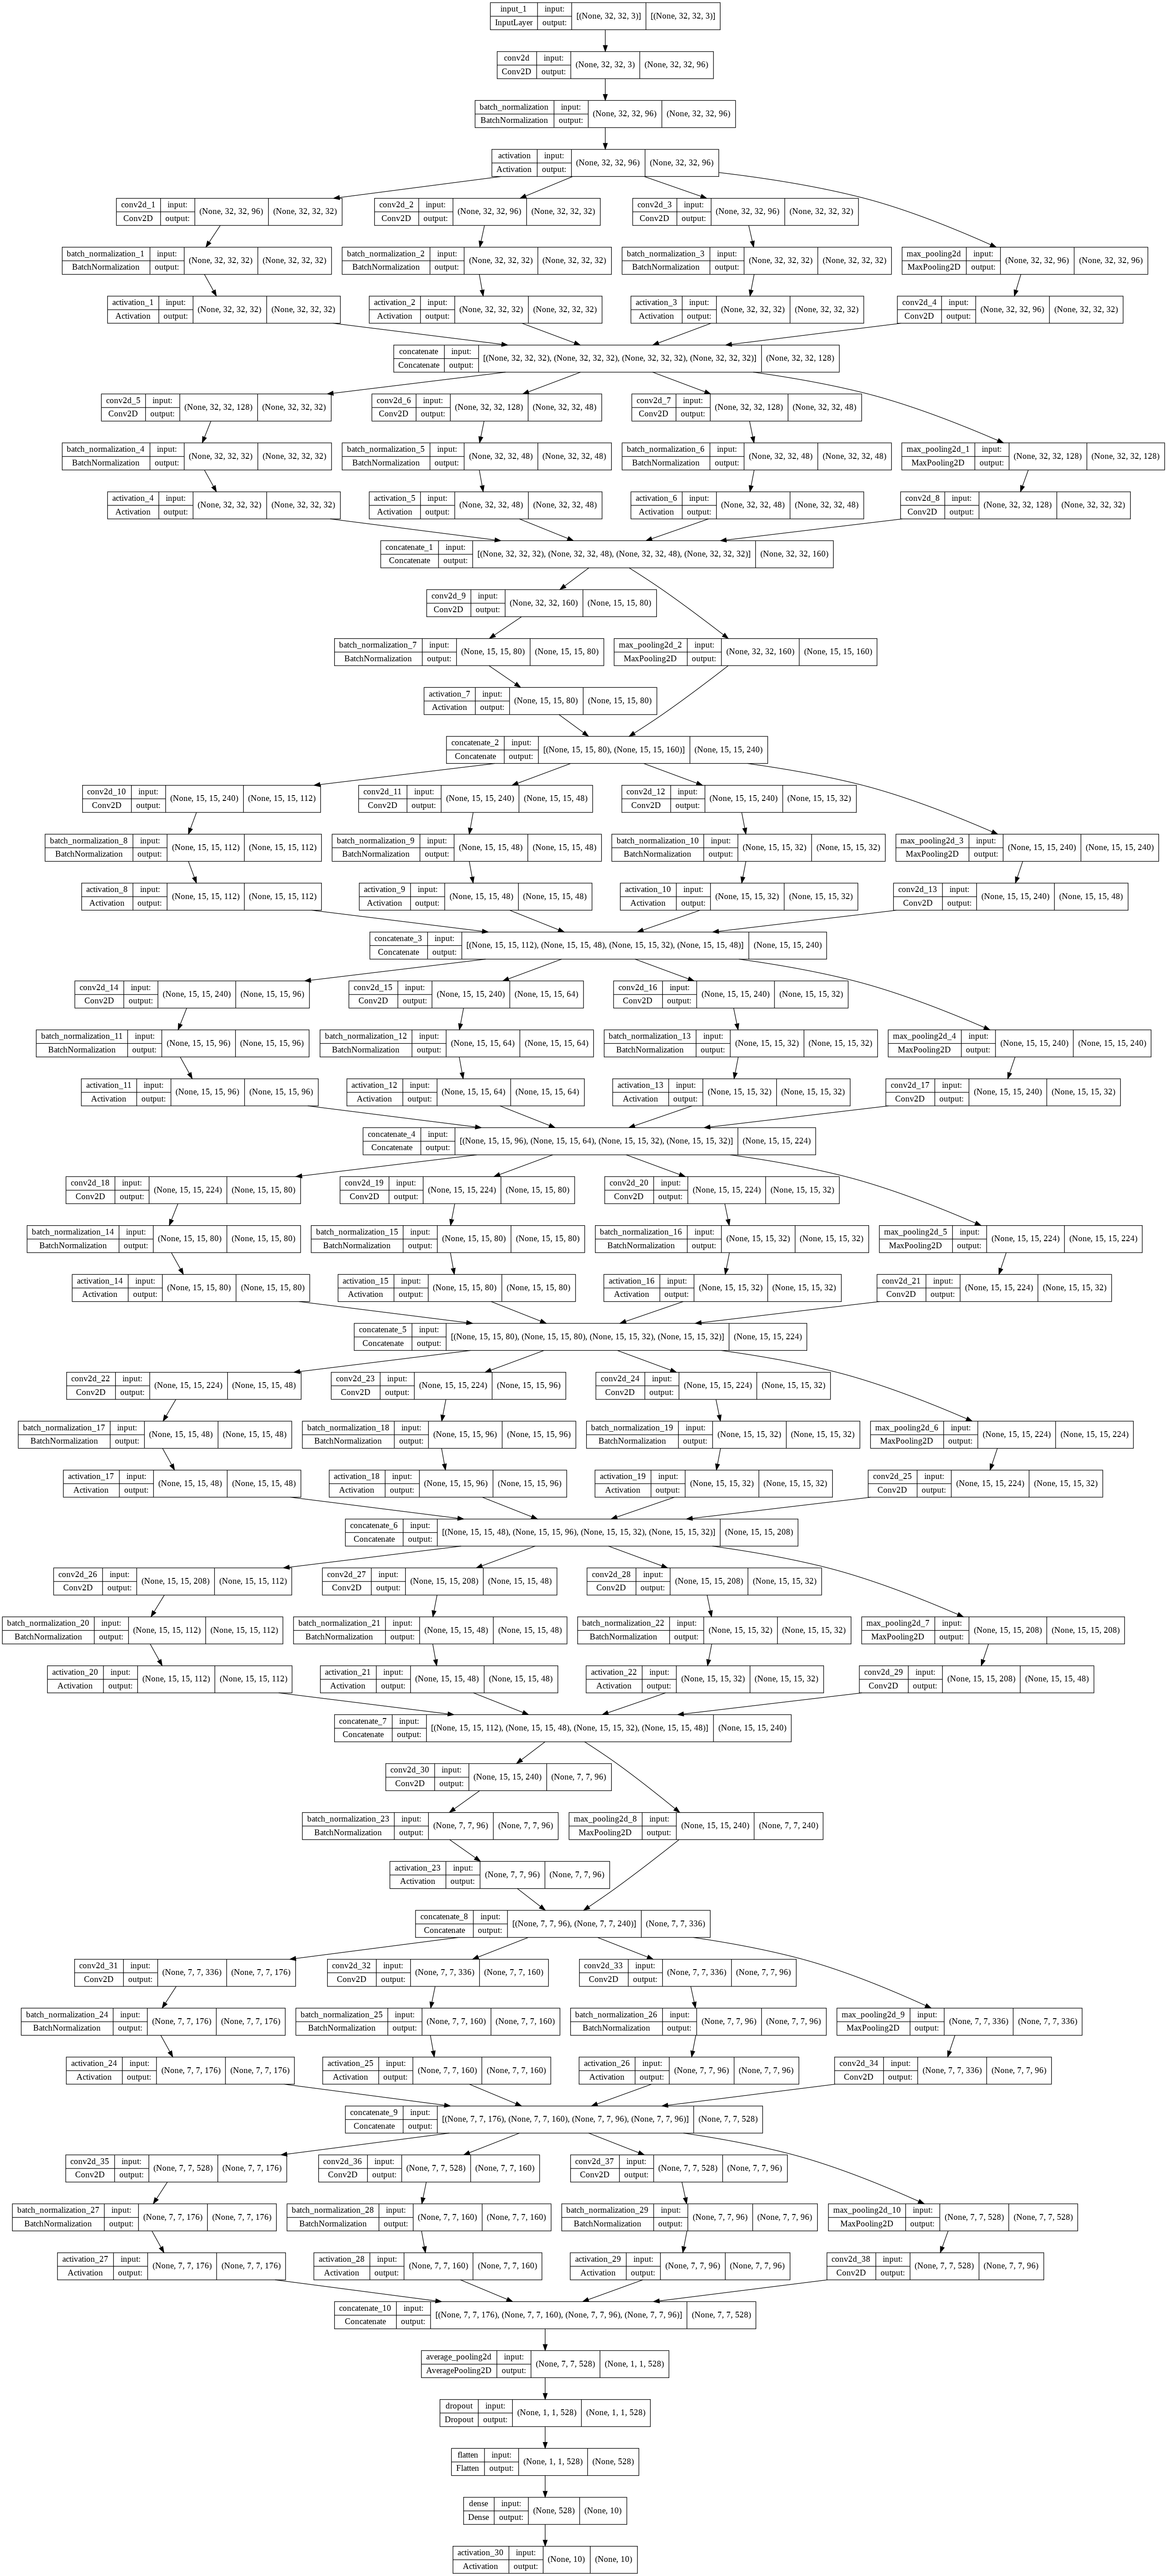

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
history = model.fit(aug.flow(trainX, trainY, batch_size=64),
          validation_data=(testX, testY),
          steps_per_epoch=len(trainX) // 64,
          epochs=NUM_EPOCHS,
          callbacks=callbacks,
          verbose=1)

Epoch 1/20
781/781 [==============================] - ETA: 0s - loss: 1.3737 - accuracy: 0.5064
Epoch 1: val_accuracy improved from -inf to 0.59130, saving model to /content/gdrive/MyDrive/Prácticas IAA/best_model_googlenet.h5
781/781 [==============================] - 112s 124ms/step - loss: 1.3737 - accuracy: 0.5064 - val_loss: 1.1422 - val_accuracy: 0.5913 - lr: 0.0050
Epoch 2/20
781/781 [==============================] - ETA: 0s - loss: 0.9222 - accuracy: 0.6735
Epoch 2: val_accuracy improved from 0.59130 to 0.70360, saving model to /content/gdrive/MyDrive/Prácticas IAA/best_model_googlenet.h5
781/781 [==============================] - 96s 123ms/step - loss: 0.9222 - accuracy: 0.6735 - val_loss: 0.8544 - val_accuracy: 0.7036 - lr: 0.0047
Epoch 3/20
781/781 [==============================] - ETA: 0s - loss: 0.7556 - accuracy: 0.7365
Epoch 3: val_accuracy improved from 0.70360 to 0.73840, saving model to /content/gdrive/MyDrive/Prácticas IAA/best_model_googlenet.h5
781/781 [=========

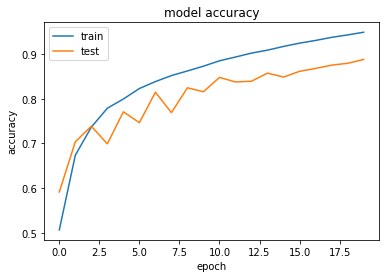

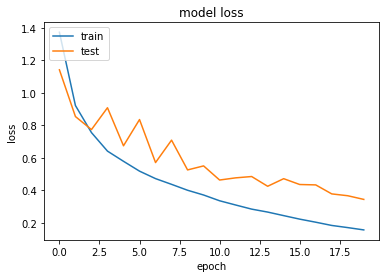

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Cargamos tensorflow que contiene a Keras.
import tensorflow as tf

# Conexión a Goolge Drive para descargar el dataset.
from google.colab import drive
drive.mount('/content/gdrive')

# Guardamos el mejor modelo
model.save('gdrive/MyDrive/best_googlenet_model.h5')

Mounted at /content/gdrive


In [ ]:
#Cargamos tensorflow que contiene a Keras.
import tensorflow as tf
# Conexión a Goolge Drive para descargar el dataset.

from google.colab import drive
drive.mount('/content/gdrive')

# Comparación de modelos mediante el dataset de tests

In [ ]:
import tensorflow as tf
from tensorflow import keras
import random
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def load_dataset() -> tuple:
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

  assert x_train.shape == (50000, 32, 32, 3)
  assert x_test.shape == (10000, 32, 32, 3)
  assert y_train.shape == (50000, 1)
  assert y_test.shape == (10000, 1)

  return (x_train, y_train), (x_test, y_test)

In [ ]:
(x_train, y_train), (x_test, y_test) = load_dataset()

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
#Cargamos tensorflow que contiene a Keras.
import tensorflow as tf

# Conexión a Goolge Drive para descargar el dataset.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Normalizing image values 

x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
# transform labels to categorical values

N_CLASSES = 10
y_train = keras.utils.to_categorical(y_train, N_CLASSES)
print("Y_train shape/type changed to ", y_train.shape, y_train.dtype)

# 10 posibles outputs
y_test = keras.utils.to_categorical(y_test, N_CLASSES)

Y_train shape/type changed to  (50000, 10) float32


# Evaluación del modelo convolucional I

In [ ]:
model_path = '/content/gdrive/MyDrive/Prácticas IAA/best_conv_I_model.h5'
model_conv_I = tf.keras.models.load_model(model_path)

In [ ]:
score = model_conv_I.evaluate(x_test, y_test)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 12s 5ms/step - loss: 0.7950 - accuracy: 0.7237
Test loss: 0.794980525970459
Test accuracy: 0.7236999869346619


My test image[6421] is a frog
My model says: frog
My test image[6611] is a ship
My model says: ship
My test image[308] is a automobile
My model says: automobile
My test image[6025] is a frog
My model says: dog
My test image[1214] is a dog
My model says: dog
My test image[6682] is a deer
My model says: deer
My test image[4545] is a cat
My model says: frog
My test image[6604] is a bird
My model says: dog
My test image[3761] is a airplane
My model says: airplane
My test image[7745] is a horse
My model says: horse


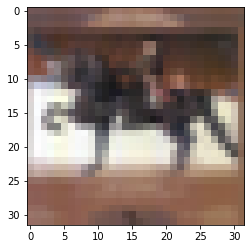

In [ ]:
class_names=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

for _ in range(10):

  index = random.choice(range(0, 10000))

  # Array with a structure -> i.e: [.0, .0, .0, 0., 1, 0., 0., 0., 0., 0.]
  result = y_test[index].argmax()

  print(f"My test image[{index}] is a {class_names[result]}")
  plt.imshow(x_test[index])

  # Result

  test_image = x_test[index]
  test_image = np.expand_dims(test_image, 0)

  predict = model_conv_I.predict(test_image)
  result_class = class_names[predict.argmax()]

  print(f"My model says: {result_class}")

# Evaluación del modelo convolucional II

In [ ]:
model_path = '/content/gdrive/MyDrive/Prácticas IAA/best_conv_II_model.h5'
model_conv_II = tf.keras.models.load_model(model_path)

In [ ]:
score = model_conv_II.evaluate(x_test, y_test)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 11s 4ms/step - loss: 0.4128 - accuracy: 0.9016
Test loss: 0.4127930700778961
Test accuracy: 0.9016000032424927


In [ ]:
from tensorflow.keras.utils import to_categorical

(X_train, Y_train), (X_test, Y_test) = load_dataset()

# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

Y_pred = model_conv_II.predict(X_test)
Y_pred_shaped = np.argmax(Y_pred, axis=1)
print(y_test)
print(Y_pred_shaped)

print('Confusion Matrix')
print(multilabel_confusion_matrix(y_test, Y_pred_shaped))
print('Classification Report')

[3 8 8 ... 5 1 7]
[3 8 8 ... 5 1 7]
Confusion Matrix
[[[8904   96]
  [  94  906]]

 [[8941   59]
  [  39  961]]

 [[8896  104]
  [ 146  854]]

 [[8876  124]
  [ 250  750]]

 [[8889  111]
  [  88  912]]

 [[8850  150]
  [ 143  857]]

 [[8849  151]
  [  32  968]]

 [[8939   61]
  [  79  921]]

 [[8951   49]
  [  58  942]]

 [[8921   79]
  [  55  945]]]
Classification Report


# Matriz de confusión con el modelo convolucional II

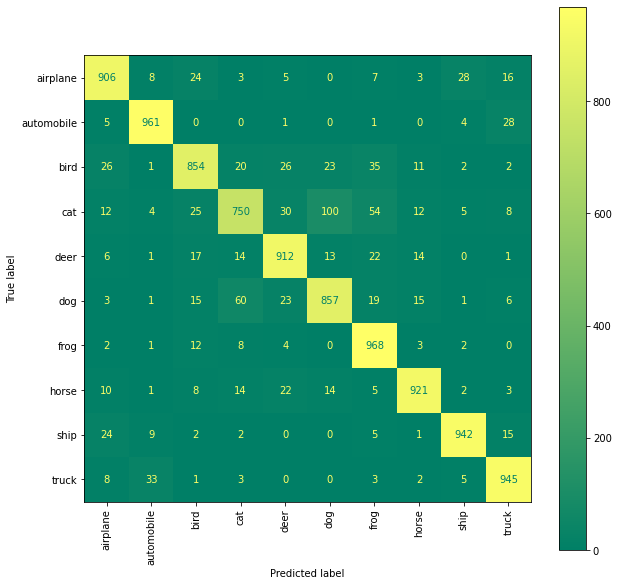

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

cm = confusion_matrix(y_test, Y_pred_shaped)

labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

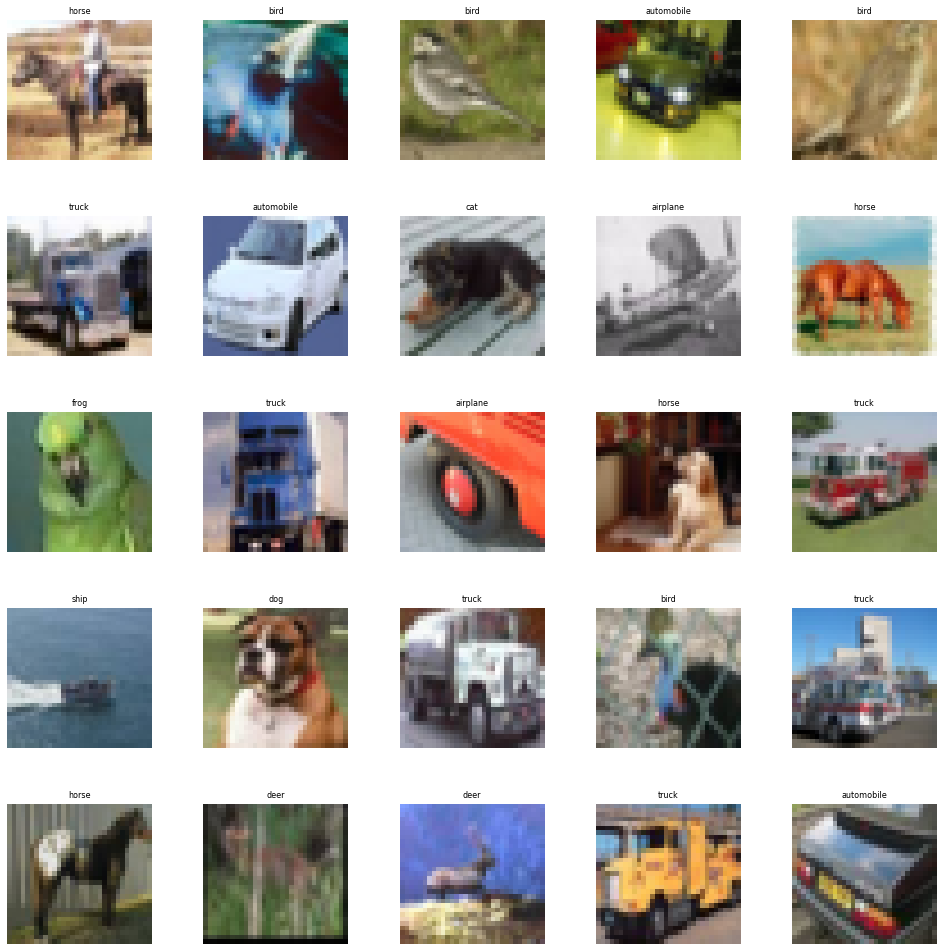

In [ ]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:])
    label_index = int(Y_pred_shaped[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
predictions = model_conv_II.predict(X_test)

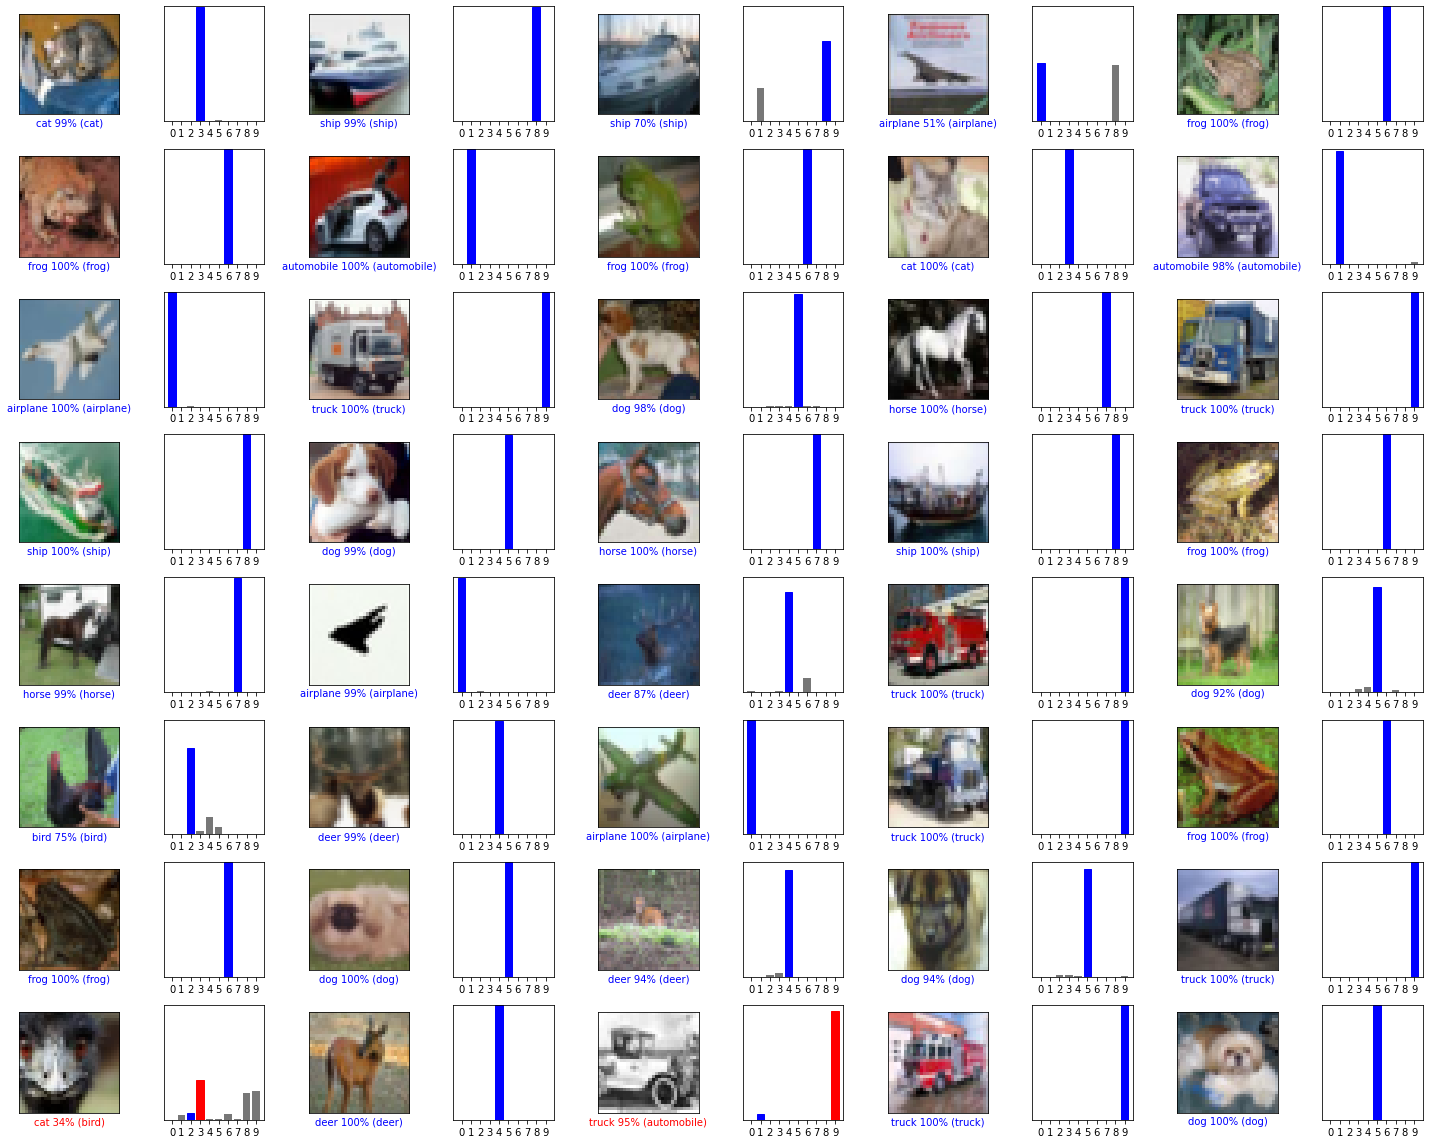

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

My test image[7102] is a airplane
My model says: airplane
My test image[1521] is a horse
My model says: horse
My test image[7948] is a automobile
My model says: automobile
My test image[1973] is a airplane
My model says: airplane
My test image[3898] is a automobile
My model says: automobile
My test image[1128] is a deer
My model says: deer
My test image[8681] is a bird
My model says: bird
My test image[1902] is a airplane
My model says: airplane
My test image[8326] is a cat
My model says: dog
My test image[2685] is a bird
My model says: deer


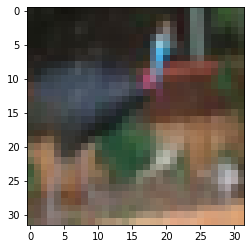

In [ ]:
class_names=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

for _ in range(10):

  index = random.choice(range(0, 10000))

  # Array with a structure -> i.e: [.0, .0, .0, 0., 1, 0., 0., 0., 0., 0.]
  result = y_test[index].argmax()

  print(f"My test image[{index}] is a {class_names[result]}")
  plt.imshow(x_test[index])

  # Result

  test_image = x_test[index]
  test_image = np.expand_dims(test_image, 0)

  predict = model_conv_II.predict(test_image)
  result_class = class_names[predict.argmax()]

  print(f"My model says: {result_class}")